In [147]:
# Source: https://www.kaggle.com/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

# Import libraries
import numpy as np
import pandas as pd 
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [148]:
global_temparature_data=pd.read_csv('GlobalTemperatures.csv')

In [149]:
global_temparature_data.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
land_average_temparature=global_temparature_data[['LandAverageTemperature']]

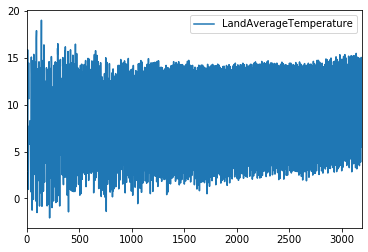

In [151]:
land_average_temparature.plot()

In [152]:
land_average_temparature.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
land_average_temparature['LandAverageTemperature'] = scaler.fit_transform(land_average_temparature['LandAverageTemperature'].values.reshape(-1,1))

/home/shotarobaba/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
land_average_temparature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 1 columns):
LandAverageTemperature    3180 non-null float64
dtypes: float64(1)
memory usage: 25.1 KB


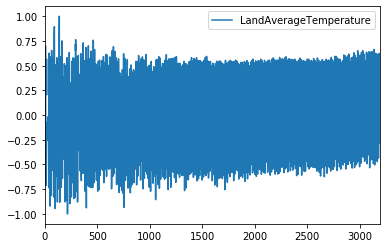

In [154]:
land_average_temparature.plot()

In [155]:
# Create test & train data to create LSTM model.
def create_test_train_data(data,look_back=100,test_data_size=0.3):
    np_data=data.values;
    data=[]
    
    for i in range(len(np_data)-look_back):
        data.append(np_data[i : i + look_back])
    
    data=np.array(data)
    test_length=int(np.round(test_data_size*data.shape[0]))
    train_length=data.shape[0] - (test_length)
    
    x_train = data[:train_length,:-1,:]
    y_train = data[:train_length,-1,:]
    
    x_test = data[train_length:,:-1]
    y_test = data[train_length:,-1,:]
        
    return (x_train, y_train, x_test, y_test)
    
    

x_train, y_train, x_test, y_test=create_test_train_data(land_average_temparature)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2164, 99, 1)
(2164, 1)
(928, 99, 1)
(928, 1)


In [156]:

# Create a LSTM model.
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [157]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [158]:
num_epochs = 100
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    
    # Forward propagation
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()


    optimiser.zero_grad()
    
    # Back pro
    loss.backward()


    optimiser.step()

Epoch  10 MSE:  nan
Epoch  20 MSE:  nan
Epoch  30 MSE:  nan
Epoch  40 MSE:  nan
Epoch  50 MSE:  nan
Epoch  60 MSE:  nan
Epoch  70 MSE:  nan
Epoch  80 MSE:  nan
Epoch  90 MSE:  nan
